Simple TensorFlow image classification model based on [this tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [21]:
# if you have to install tensorflow, idk if opencv-python is needed
# ! pip install tensorflow opencv-python
! pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomi

In [1]:
import tensorflow as tf

In [23]:
# tf automatically labels the data based on the folder name
# and splits them into batches

batch_size = 32
img_height = 92
img_width = 92
data_dir = '../old group/algae_dataset'

# data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(92,92), batch_size=32, shuffle=True)

# change label_mode to use sparse_categorical_crossentropy
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode = 'categorical',
    seed=1738,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2197 files belonging to 5 classes.


In [28]:
n = int(len(dataset))
train_size = int(n * 0.7)
val_size = int(n * 0.2)
test_size = int(n * 0.1)

train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + test_size).take(test_size)

In [24]:
class_names = dataset.class_names
print(class_names)

['closterium', 'microcystis', 'nitzschia', 'non-algae', 'oscillatoria']


In [34]:
# build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Rescaling

model = Sequential()

model.add(Rescaling(1./255,  input_shape=(img_height, img_width, 3)))

# # these layers are from the tutorial
model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

# 5 classes
model.add(Dense(5, activation='softmax'))

In [40]:
# SparseCategoricalCrossentropy when there are two or more label classes
model.compile(
            optimizer='adam',
    loss='categorical_crossentropy',
            metrics=['accuracy']
        )
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 92, 92, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 92, 92, 32)        2432      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 46, 46, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                

In [41]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1)

Epoch 1/20
69/69 [==============================] - 7s 95ms/step - loss: 1.3900 - accuracy: 0.3960 - val_loss: 1.4651 - val_accuracy: 0.4188
Epoch 2/20
69/69 [==============================] - 6s 91ms/step - loss: 1.3615 - accuracy: 0.3964 - val_loss: 1.4249 - val_accuracy: 0.4188
Epoch 3/20
69/69 [==============================] - 6s 91ms/step - loss: 1.3553 - accuracy: 0.4096 - val_loss: 1.3588 - val_accuracy: 0.4188
Epoch 4/20
69/69 [==============================] - 6s 92ms/step - loss: 1.3475 - accuracy: 0.4151 - val_loss: 1.3677 - val_accuracy: 0.4188
Epoch 5/20
69/69 [==============================] - 6s 93ms/step - loss: 1.3391 - accuracy: 0.4183 - val_loss: 1.3434 - val_accuracy: 0.4188
Epoch 6/20
69/69 [==============================] - 6s 91ms/step - loss: 1.3160 - accuracy: 0.4142 - val_loss: 1.3388 - val_accuracy: 0.4188
Epoch 7/20
69/69 [==============================] - 6s 92ms/step - loss: 1.2952 - accuracy: 0.4178 - val_loss: 1.3107 - val_accuracy: 0.4206
Epoch 8/20
69

In [45]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 0s 29ms/step
tf.Tensor(0.9529412, shape=(), dtype=float32) tf.Tensor(0.84375, shape=(), dtype=float32) tf.Tensor(0.9604167, shape=(), dtype=float32)


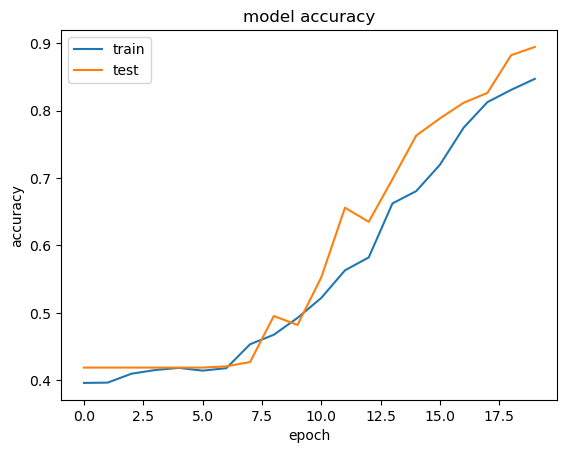

In [42]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

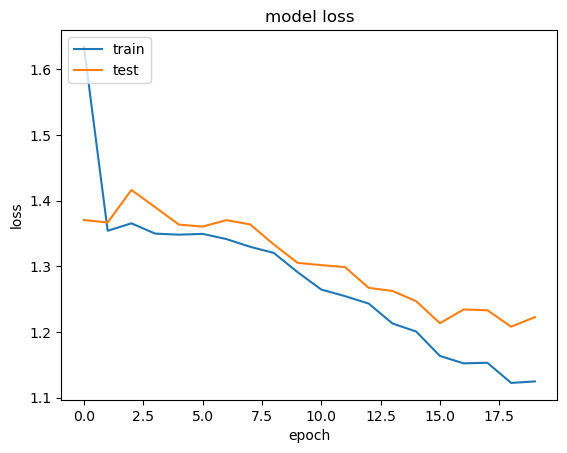

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
# save the model to export
model.save("tf_model.h5")

# save the weights
model.save_weights("tf_model_weights.h5")

/Users/mateovelazquez/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
model = tf.keras.models.load_model("tf_model.h5")

In [48]:
tf.saved_model.save(model, "tf_model")
!python -m tf2onnx.convert --saved-model tf_model --output "tf_model.onnx"
!zip -r tf_model.zip tf_model

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2023-11-13 14:58:34,899 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2023-11-13 14:58:34,900 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-11-13 14:58:35,244 - INFO - Signatures found in model: [serving_default].
2023-11-13 14:58:35,244 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-11-13 14:58:35,244 - INFO - Output names: ['dense_9']
2023-11-13 14:58:35,244 - WARNING - Could not search for non-variable resources. Concrete function internal representation may have changed.
2023-11-13 14:58:35,373 - INFO - Using tensorflow=2.13.0, onnx=1.14.1, tf2onnx=1.15.1/37820d
2023-11-13 14:58:35,373 - INFO - Using opse

Convert model into ESP-DL